# Tracking Lorenz 63 using continuous-discrete Extended / Ensemble / Unscented Kalman filter

Note that EnKF outperforms EKF for slow/irregular sample rates.
Also, UKF returns NaNs if initial state covariance is too large. (e.g. sd=20).

## Setup

In [1]:
%matplotlib inline
import dynamax
import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax.random as jr
from jax import vmap
from jax import lax
from jaxtyping import Float, Array
from typing import Callable, NamedTuple, Tuple, Optional, Union
from jaxtyping import Array, Float, PyTree

from dynamax.parameters import ParameterProperties

# For pretty print of ndarrays
jnp.set_printoptions(formatter={"float_kind": "{:.2f}".format})

# import discrete-time filters
from dynamax.nonlinear_gaussian_ssm import ParamsNLGSSM, UKFHyperParams
from dynamax.nonlinear_gaussian_ssm import extended_kalman_smoother, unscented_kalman_smoother

# import continuous-discrete nonlinear Gaussian SSM code
import sys
sys.path.append("..")
sys.path.append("../src")
# use custom src codebase
from utils.plotting import *
from continuous_discrete_nonlinear_gaussian_ssm import ContDiscreteNonlinearGaussianSSM
from continuous_discrete_nonlinear_gaussian_ssm import cdnlgssm_filter
from continuous_discrete_nonlinear_gaussian_ssm import EnKFHyperParams, EKFHyperParams, UKFHyperParams

# set up drift function
from continuous_discrete_nonlinear_gaussian_ssm.models import (
    LearnableFunction,
    ConstantLearnableFunction,
    LinearLearnableFunction,
)


/opt/homebrew/anaconda3/envs/hduq/lib/python3.11/site-packages/equinox/_ad.py:733: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(


In [2]:
def plot_lorenz(time_grid, x_tr, x_obs, x_est=None, est_type=""):
    plt.figure()
    n_states = x_tr.shape[1]
    for i in range(n_states):
        plt.plot(time_grid, x_tr[:, i], color=f"C{i}", alpha=0.5, linewidth=4, label=f"True State {i}")

    if x_est is not None:
        for i in range(n_states):
            plt.plot(
                time_grid, x_est[:, i], "--", color=f"C{i}", linewidth=1.5, label=f"{est_type} Estimated State {i}"
            )

    n_obs = x_obs.shape[1]
    for i in range(n_obs):
        plt.plot(time_grid, x_obs[:, i], "ok", fillstyle="none", ms=1.5, label=f"Measurement {i}")

    plt.xlabel("Time $t$")
    # plt.ylabel("Pendulum angle $x_{1,k}$")
    # plt.xlim(0, 5)
    # plt.ylim(-3, 5)
    # plt.xticks(jnp.arange(0.5, 4.6, 0.5))
    # plt.yticks(jnp.arange(-3, 5.1, 1))
    # plt.gca().set_aspect(0.5)
    plt.legend(loc=1, borderpad=0.5, handlelength=4, fancybox=False, edgecolor="k")
    plt.show()

In [3]:
## Main settings
state_dim = 3
emission_dim = 1


class CustomDrift(LearnableFunction):
    params: Union[Float[Array, "state_dim"], ParameterProperties]

    def f(self, x, u=None, t=None):
        foo = jnp.array(
            [
                self.params[0] * (x[1] - x[0]),
                self.params[1] * x[0] - x[1] - x[0] * x[2],
                -self.params[2] * x[2] + x[0] * x[1],
            ]
        )
        return foo


learnable_drift = CustomDrift(params=jnp.array([10.0, 28.0, 8 / 3]))
learnable_emission = LinearLearnableFunction(params=jnp.array([[1.0, 0.0, 0.0]]))
learnable_diffusion_cov = ConstantLearnableFunction(params=jnp.eye(state_dim))
learnable_diffusion_coefficient = ConstantLearnableFunction(params=0.1 * jnp.eye(state_dim))
learnable_emission_cov = ConstantLearnableFunction(params=jnp.eye(emission_dim))

true_model = ContDiscreteNonlinearGaussianSSM(state_dim, emission_dim)

## Fast sample rate and modest initial state covariance

Text(0.5, 1.0, 'Training Emissions')

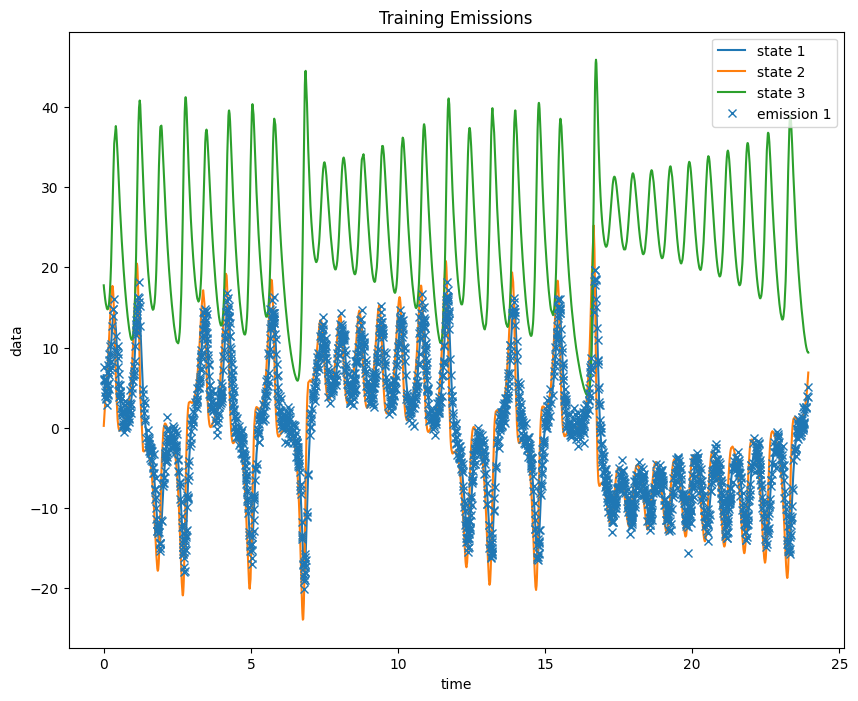

In [4]:
## Code
init_state_sd = 10
T = 40
num_timesteps = 4000
t_emissions = jnp.array(sorted(jr.uniform(jr.PRNGKey(0), (num_timesteps, 1), minval=0, maxval=T)))

# set timesteps to be 400 timesteps at dt intervals
# t_emissions = jnp.arange(num_timesteps) * dt
# t_emissions = t_emissions.reshape(-1, 1)

key = jr.PRNGKey(0)
key, key_root = jr.split(key)
true_params, param_props = true_model.initialize(
    key,
    initial_mean=jnp.array([0.0, 0.0, 0.0]),
    initial_cov=jnp.eye(state_dim) * (init_state_sd**2),  # want to initialize at ~ initial mean
    dynamics_drift=learnable_drift,
    dynamics_diffusion_coefficient=learnable_diffusion_coefficient,
    dynamics_diffusion_cov=learnable_diffusion_cov,
    dynamics_approx_order=1.0,
    emission_function=learnable_emission,
    emission_cov=learnable_emission_cov,
)

key, key_root = jr.split(key)
true_states, emissions = true_model.sample(true_params, key, num_timesteps, t_emissions)

# Plot the true states and emissions
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(t_emissions, true_states[:, 0], color="C0", label="state 1")
ax.plot(t_emissions, true_states[:, 1], color="C1", label="state 2")
ax.plot(t_emissions, true_states[:, 2], color="C2", label="state 3")
ax.plot(t_emissions, emissions[:, 0], "x", color="C0", label="emission 1")
ax.legend()
ax.set_ylabel("data")
ax.set_xlabel("time")
ax.set_title("Training Emissions")

### Extended Kalman Filter

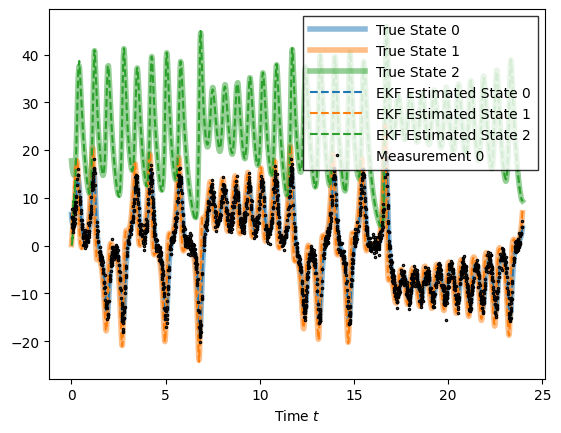

In [5]:
ekf_filtered = cdnlgssm_filter(true_params, emissions, EKFHyperParams(), t_emissions)
plot_lorenz(t_emissions, true_states, emissions, x_est=ekf_filtered.filtered_means, est_type="EKF")

### Ensemble Kalman Filter

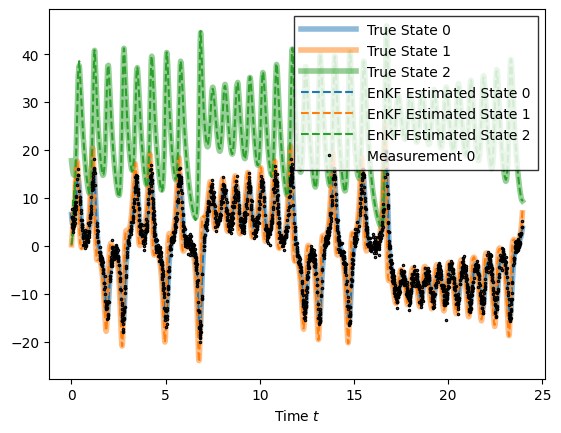

In [6]:
enkf_filtered = cdnlgssm_filter(true_params, emissions, EnKFHyperParams(), t_emissions)
plot_lorenz(t_emissions, true_states, emissions, x_est=enkf_filtered.filtered_means, est_type="EnKF")

### Unscented Kalman Filter


[[5.94 -0.00 -0.00]
 [6.74 0.87 0.00]
 [6.12 1.72 0.14]
 ...
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]


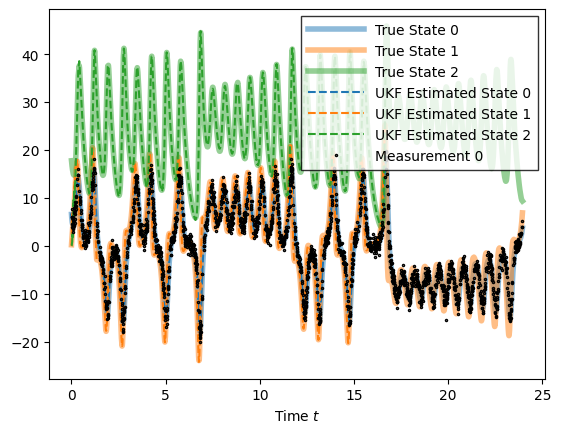

In [7]:
ukf_filtered = cdnlgssm_filter(true_params, emissions, UKFHyperParams(), t_emissions)
print(ukf_filtered.filtered_means)
plot_lorenz(t_emissions, true_states, emissions, x_est=ukf_filtered.filtered_means, est_type="UKF")

## Slow sample rate and larger initial state covariance

Text(0.5, 1.0, 'Training Emissions')

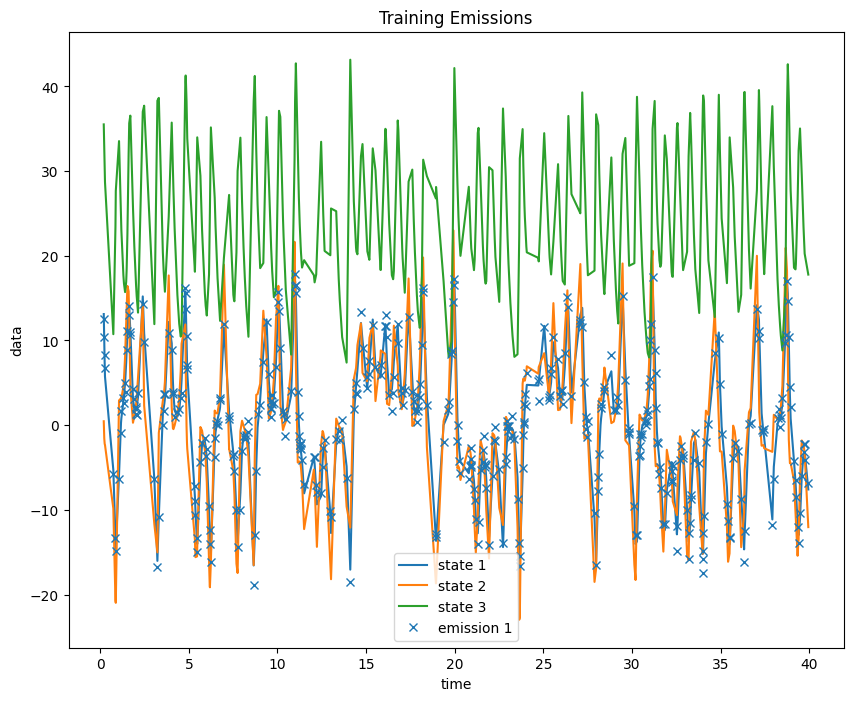

In [12]:
## Code

init_state_sd = 20
T = 40
num_timesteps = 400
t_emissions = jnp.array(sorted(jr.uniform(jr.PRNGKey(0), (num_timesteps, 1), minval=0, maxval=T)))

# set timesteps to be 400 timesteps at dt intervals
# t_emissions = jnp.arange(num_timesteps) * dt
# t_emissions = t_emissions.reshape(-1, 1)

key = jr.PRNGKey(0)
key, key_root = jr.split(key)
true_params, param_props = true_model.initialize(
    key,
    initial_mean=jnp.array([0.0, 0.0, 0.0]),
    initial_cov=jnp.eye(state_dim) * (init_state_sd**2),  # want to initialize at ~ initial mean
    dynamics_drift=learnable_drift,
    dynamics_diffusion_coefficient=learnable_diffusion_coefficient,
    dynamics_diffusion_cov=learnable_diffusion_cov,
    dynamics_approx_order=1.0,
    emission_function=learnable_emission,
    emission_cov=learnable_emission_cov,
)

key, key_root = jr.split(key)
true_states, emissions = true_model.sample(true_params, key, num_timesteps, t_emissions)

# Plot the true states and emissions
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(t_emissions, true_states[:, 0], color="C0", label="state 1")
ax.plot(t_emissions, true_states[:, 1], color="C1", label="state 2")
ax.plot(t_emissions, true_states[:, 2], color="C2", label="state 3")
ax.plot(t_emissions, emissions[:, 0], "x", color="C0", label="emission 1")
ax.legend()
ax.set_ylabel("data")
ax.set_xlabel("time")
ax.set_title("Training Emissions")

### Extended Kalman Filter

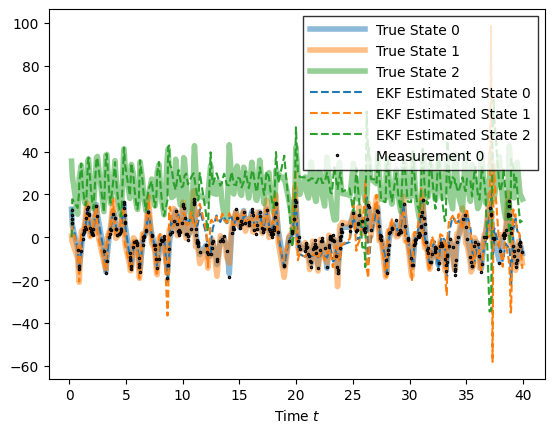

In [13]:
ekf_filtered = cdnlgssm_filter(true_params, emissions, EKFHyperParams(), t_emissions)
plot_lorenz(t_emissions, true_states, emissions, x_est=ekf_filtered.filtered_means, est_type="EKF")

### Ensemble Kalman Filter

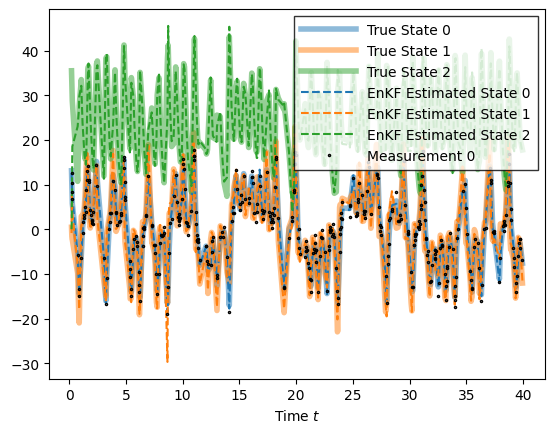

In [14]:
enkf_filtered = cdnlgssm_filter(true_params, emissions, EnKFHyperParams(), t_emissions)
plot_lorenz(t_emissions, true_states, emissions, x_est=enkf_filtered.filtered_means, est_type="EnKF")

### Unscented Kalman Filter


[[12.53 -0.00 -0.00]
 [nan nan nan]
 [nan nan nan]
 ...
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]


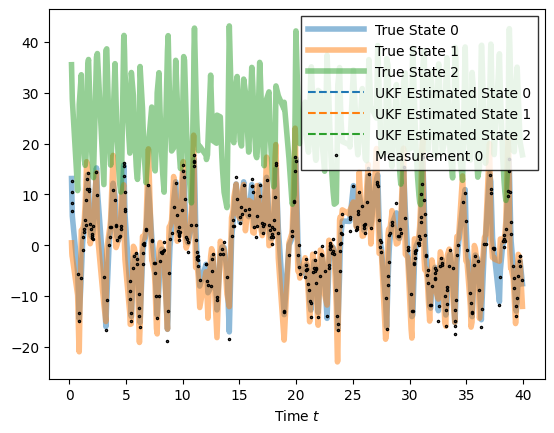

In [15]:
ukf_filtered = cdnlgssm_filter(true_params, emissions, UKFHyperParams(), t_emissions)
print(ukf_filtered.filtered_means)
plot_lorenz(t_emissions, true_states, emissions, x_est=ukf_filtered.filtered_means, est_type="UKF")
